<a href="https://colab.research.google.com/github/Gape-42/IniciacaoCientifica/blob/main/Simulated_Annealing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Importando bibliotecas**




In [ ]:
import pandas as pd
import random
import math
import copy
from matplotlib import pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

Carregando conjunto de dados

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
dados = pd.read_csv("/content/Vertebral.csv")
dados = shuffle(dados)
X = dados.iloc[:,:-1]
Y = dados.iloc[:,-1]

Gerando os conjuntos de treino, teste e validação

In [ ]:
x_treino,x_temp,y_treino,y_temp=train_test_split(X,Y,test_size=0.5,stratify=Y)
x_validacao,x_teste,y_validacao,y_teste=train_test_split(x_temp,y_temp,test_size=0.5, stratify = y_temp)

 Constantes

In [ ]:
SA_MAX = 5
ALFA = 0.995

Definindo os individuos

In [ ]:
class individuos:
  def __init__(self, criterio, profundidade, min_samples_leaf, min_samples_split, splitter, fitness):
    self.criterio = criterio
    self.profundidade = profundidade
    self.min_samples_leaf = min_samples_leaf
    self.min_samples_split = min_samples_split
    self.splitter = splitter
    self.fitness = fitness

Funções

In [ ]:
def arvore_decisao(individuo):
  AD = DecisionTreeClassifier(criterion=individuo.criterio, max_depth=individuo.profundidade, min_samples_leaf=individuo.min_samples_leaf ,min_samples_split=individuo.min_samples_split ,splitter=individuo.splitter)
  AD.fit(x_treino,y_treino)
  opiniao = AD.predict(x_validacao)
  return accuracy_score(y_validacao, opiniao)

def arvore_decisao_teste(individuo):
  AD = DecisionTreeClassifier(criterion=individuo.criterio, max_depth=individuo.profundidade, min_samples_leaf=individuo.min_samples_leaf ,min_samples_split=individuo.min_samples_split ,splitter=individuo.splitter)
  AD.fit(x_treino,y_treino)
  opiniao = AD.predict(x_teste)
  return accuracy_score(y_teste, opiniao)

def printarIndividuo(individuo):
  print("critério:\t\t", individuo.criterio)
  print("profundidade:\t\t", individuo.profundidade)
  print("min_samples_leaf:\t", individuo.min_samples_leaf)
  print("min_samples_split:\t", individuo.min_samples_split)
  print("splitter:\t\t", individuo.splitter)
  print("fitness:\t\t", individuo.fitness)
  print()

def metropolis():
    return random.random()

def gerarIndividuoAleatorio():
    individuo = individuos(None, None, None, None, None, None)
    individuo.criterio = random.choice(["gini", "entropy"])
    individuo.profundidade = random.randint(1, 10)
    individuo.min_samples_leaf = random.randint(1, 10)
    individuo.min_samples_split = random.randint(2, 15)
    individuo.splitter = random.choice(["best", "random"])
    individuo.fitness = 0
    return individuo

#Esolhe um atributo para modificar e fazer um vizinho
def escolherAtributo():
    return random.choice(["criterio", "profundidade", "min_samples_leaf", "min_samples_split", "splitter"])

def gerarVizinho(individuo, Atributo):
    vizinho = copy.copy(individuo) #Por que altera o original sem copy?

    if Atributo == "criterio":
        vizinho.criterio = random.choice(["gini", "entropy"])
    if Atributo == "profundidade":
        vizinho.profundidade = random.randint(1, 10)
    if Atributo == "min_samples_leaf":
        vizinho.min_samples_leaf = random.randint(1, 10)
    if Atributo == "min_samples_split":
        vizinho.min_samples_split = random.randint(2, 15)
    if Atributo == "splitter":
        vizinho.splitter = random.choice(["best", "random"])

    return vizinho


#Variação da solução atual
#∆E = Ei+1 - Ei
def variacaoSolucao(individuo, vizinho):
    return vizinho.fitness - individuo.fitness

#Probabilidade de aceitar piora (minimização)
# P(∆E) = e^(∆E/T)
def probabilidadePiora(variacao, temperatura):
    return math.exp(variacao / temperatura)

#Resfriamento
def resfriamento(temperatura):
    return temperatura * ALFA

#Gerar temperatura inicial

def temperaturaInicial():
    ind1 = gerarIndividuoAleatorio()
    vizinhos = []
    TempInicial = 0
    # ind1.fitness = arvore_decisao(ind1)   #Remover linha
    for i in range (3):
      vizinhos.append(gerarVizinho(ind1, escolherAtributo()))
      vizinhos[i].fitness = arvore_decisao(vizinhos[i])

    for i in range (3):
      TempInicial = TempInicial + vizinhos[i].fitness
    TempInicial = TempInicial/3

    return TempInicial


Iniciando o algoritmo

In [ ]:
solucao_atual = gerarIndividuoAleatorio()
solucao_atual.fitness = arvore_decisao(solucao_atual)
melhor_individuo = solucao_atual
temperatura = temperaturaInicial()
iteracao = 0

#gráfico
temperaturas = []
melhores_individuos = []
# temperaturas.append(temperatura)
# melhores_individuos.append(solucao_atual)


while(temperatura > 0.005):
    #grafico
    temperaturas.append(temperatura)
    melhores_individuos.append(melhor_individuo.fitness)

    while(iteracao < SA_MAX):
        iteracao += 1
        vizinho = gerarVizinho(solucao_atual, escolherAtributo())
        vizinho.fitness = arvore_decisao(vizinho)

        #verificação do critério de aceitação
        # print("inicial:")
        # printarIndividuo(solucao_atual)
        # print("vizinho:")
        # printarIndividuo(vizinho)

        #delta maior que 0, aceita
        delta = variacaoSolucao(solucao_atual, vizinho)
        # print("delta: ", delta)

        if(delta > 0):
            # print("caso 1")
            solucao_atual = vizinho
            if(vizinho.fitness > melhor_individuo.fitness):
                # print("caso 2")
                melhor_individuo = vizinho
        else:
            # print("caso 3")
            x = metropolis()
            piora = probabilidadePiora(delta, temperatura)
            # print("x:", x)
            # print("piora:", piora)
            if(x < piora): #verifcar se é < ou >
                # print("caso 4")
                solucao_atual = vizinho

    temperatura = resfriamento(temperatura)
    iteracao = 0



solucao_atual = melhor_individuo

printarIndividuo(solucao_atual)

critério:		 entropy
profundidade:		 4
min_samples_leaf:	 4
min_samples_split:	 5
splitter:		 random
fitness:		 0.8831168831168831



Gerando o gráfico

In [ ]:
# plt.title("Fitness por temperatura")
# plt.xlabel("Temperatura")
# plt.ylabel("Fitness")
# plt.plot(temperaturas, melhores_individuos)

# ax = plt.gca()
# ax.invert_xaxis()

# plt.grid(True)
# plt.show()

# # print("Temperaturas", temperaturas)
# # print("Melhores Individuos", melhores_individuos)
# # print(len(temperaturas))
# # print(len(melhores_individuos))

Grafico V2

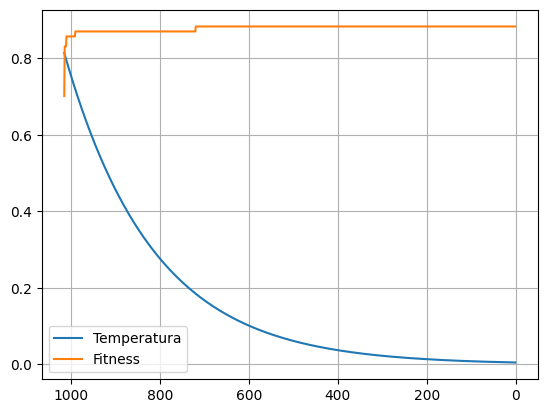

1016
[0.8138528138528138, 0.8097835497835497, 0.8057346320346319, 0.8017059588744587, 0.7976974290800865, 0.793708941934686, 0.7897403972250125, 0.7857916952388875, 0.781862736762693, 0.7779534230788796, 0.7740636559634853, 0.7701933376836678, 0.7663423709952495, 0.7625106591402733, 0.7586981058445719, 0.754904615315349, 0.7511300922387723, 0.7473744417775784, 0.7436375695686905, 0.739919381720847, 0.7362197848122428, 0.7325386858881816, 0.7288759924587407, 0.725231612496447, 0.7216054544339647, 0.7179974271617949, 0.714407440025986, 0.7108354028258561, 0.7072812258117268, 0.7037448196826682, 0.7002260955842549, 0.6967249651063335, 0.6932413402808019, 0.6897751335793979, 0.6863262579115009, 0.6828946266219434, 0.6794801534888337, 0.6760827527213895, 0.6727023389577825, 0.6693388272629937, 0.6659921331266787, 0.6626621724610453, 0.6593488615987401, 0.6560521172907464, 0.6527718567042927, 0.6495079974207713, 0.6462604574336674, 0.643029155146499, 0.6398140093707666, 0.6366149393239128, 0

In [ ]:
quantidade_temperaturas = len(temperaturas)
id_temperaturas =  list(range(quantidade_temperaturas, 0, -1))
ax1 = plt.gca()
ax1.invert_xaxis()
plt.grid(True)
plt.plot(id_temperaturas, temperaturas, label="Temperatura")
plt.plot(id_temperaturas, melhores_individuos, label="Fitness")
plt.legend()
plt.show()

print(quantidade_temperaturas)
print(temperaturas)
print(melhores_individuos)

Testando a melhor configuração

In [ ]:
acuracia  = arvore_decisao_teste(solucao_atual)
printarIndividuo(solucao_atual)
print("Acurácia: ", acuracia)

# critério:		 entropy
# profundidade:		 9
# min_samples_leaf:	 6
# min_samples_split:	 3
# splitter:		 random
# fitness:		 0.961038961038961

critério:		 entropy
profundidade:		 4
min_samples_leaf:	 4
min_samples_split:	 5
splitter:		 random
fitness:		 0.8831168831168831

Acurácia:  0.7307692307692307


# Tarefas:

* ✅ Definir alfa como variável global
* ✅ Fazer nova árvore de decisão
 * Mesma função, trocar x_validacao e y_validacao por x_teste e y_teste
* ✅ Plotar ID da temperatura
* ✅ Fazer o teste do SA e do AG
* Random Forest